In [1]:
import torch
from math import pi,sqrt,log,e,exp
from time import time
from matplotlib import pyplot
import numpy as np
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm
device = torch.device("cuda:7")

from src.training.weighted_dataset.dkl_training import BasicStatefulDKLTrainer
from src.training.weighted_dataset.variance_training import BasicStatefulVarTrainer
from src.models.flows.sequential import InvertibleSequentialFlow
from src.models.flows.coupling_cells.real_nvp import RealNVP
from src.models.flows.coupling_cells.piecewise_coupling.piecewise_linear import PWLinearCoupling
from src.models.flows.sampling import UniformSampler,FactorizedGaussianSampler
from src.models.flows.analytic_flows.element_wise import InvertibleAnalyticSigmoid
from src.integration.flat_survey_integrator import FlatSurveySamplingIntegrator
from src.integration.dkltrainer_integrator import DKLAdaptiveSurveyIntegrator
from src import setup_std_stream_logger

setup_std_stream_logger(debug=True)

# Debugging the DKL training

In [2]:
posterior=UniformSampler(d=2,low=0.,high=1.,device=device)
prior=UniformSampler(d=2,low=0.,high=1.,device=device)

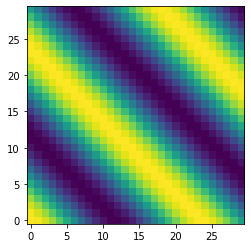

In [3]:
# a function with a small amplitude and no zero

def nonzerocos(x):
    return 1+torch.cos(4*(x[:,0]+x[:,1]))**2

n = 30
plt.imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower")
plt.show()

In [4]:
# We add a layer for the neural net that maps the unit hypercube to -1,1

class Reshift(torch.nn.Module):
    def forward(self,x):
        return (x-0.5)*2.

In [42]:
model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=256,
              n_hidden=8,
              n_bins=32,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=256,
              n_hidden=8,
              n_bins=32,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device), 
])

trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)


optim = torch.optim.Adam(model.parameters(),lr=1.e-3)

trainer.set_config(n_epochs=30, minibatch_size=20000, optim=optim)

integrator=FlatSurveySamplingIntegrator(nonzerocos,trainer,2,device=device, verbosity=3, trainer_verbosity=3)

In [43]:
result=integrator.integrate(8,1)

Starting integration
Initializing the survey phase
Starting the survey phase
Training on batch: 100000 points
Epoch 1/30
Loss: 9.253e-04
Loss: 8.225e-04
Loss: -4.009e-04
Loss: -1.215e-03
Loss: -2.188e-03
Epoch 2/30
Loss: -4.225e-03
Loss: -3.742e-03
Loss: -3.554e-03
Loss: -5.485e-03
Loss: -8.760e-03
Epoch 3/30
Loss: -1.353e-02
Loss: -1.384e-02
Loss: -1.469e-02
Loss: -1.845e-02
Loss: -2.330e-02
Epoch 4/30
Loss: -2.298e-02
Loss: -2.402e-02
Loss: -2.179e-02
Loss: -2.625e-02
Loss: -3.040e-02
Epoch 5/30
Loss: -3.161e-02
Loss: -3.191e-02
Loss: -3.118e-02
Loss: -3.849e-02
Loss: -3.927e-02
Epoch 6/30
Loss: -4.352e-02
Loss: -4.389e-02
Loss: -3.877e-02
Loss: -5.081e-02
Loss: -4.968e-02
Epoch 7/30
Loss: -5.100e-02
Loss: -5.208e-02
Loss: -4.985e-02
Loss: -6.024e-02
Loss: -5.867e-02
Epoch 8/30
Loss: -6.162e-02
Loss: -6.182e-02
Loss: -6.181e-02
Loss: -7.235e-02
Loss: -6.443e-02
Epoch 9/30
Loss: -7.218e-02
Loss: -6.727e-02
Loss: -6.436e-02
Loss: -7.808e-02
Loss: -7.404e-02
Epoch 10/30
Loss: -7.131e-02

Loss: -8.323e-02
Loss: -8.040e-02
Loss: -7.754e-02
Loss: -8.615e-02
Epoch 24/30
Loss: -8.655e-02
Loss: -8.239e-02
Loss: -8.222e-02
Loss: -7.808e-02
Loss: -8.663e-02
Epoch 25/30
Loss: -8.733e-02
Loss: -8.314e-02
Loss: -8.157e-02
Loss: -7.830e-02
Loss: -8.735e-02
Epoch 26/30
Loss: -8.610e-02
Loss: -8.319e-02
Loss: -8.210e-02
Loss: -7.805e-02
Loss: -8.602e-02
Epoch 27/30
Loss: -8.699e-02
Loss: -8.285e-02
Loss: -8.072e-02
Loss: -7.860e-02
Loss: -8.591e-02
Epoch 28/30
Loss: -8.648e-02
Loss: -8.346e-02
Loss: -8.081e-02
Loss: -7.847e-02
Loss: -8.669e-02
Epoch 29/30
Loss: -8.692e-02
Loss: -8.475e-02
Loss: -8.137e-02
Loss: -7.844e-02
Loss: -8.755e-02
Epoch 30/30
Loss: -8.633e-02
Loss: -8.489e-02
Loss: -8.187e-02
Loss: -7.790e-02
Loss: -8.723e-02
Integral: 1.496e+00 +/- 1.112e-03
Training on batch: 100000 points
Epoch 1/30
Loss: -7.332e-02
Loss: -6.701e-02
Loss: -7.749e-02
Loss: -7.317e-02
Loss: -7.959e-02
Epoch 2/30
Loss: -7.859e-02
Loss: -7.290e-02
Loss: -8.168e-02
Loss: -7.776e-02
Loss: -8.35

Epoch 16/30
Loss: -8.392e-02
Loss: -7.816e-02
Loss: -9.736e-02
Loss: -8.544e-02
Loss: -9.261e-02
Epoch 17/30
Loss: -8.407e-02
Loss: -7.808e-02
Loss: -9.767e-02
Loss: -8.513e-02
Loss: -9.224e-02
Epoch 18/30
Loss: -8.500e-02
Loss: -7.760e-02
Loss: -9.730e-02
Loss: -8.587e-02
Loss: -9.072e-02
Epoch 19/30
Loss: -8.493e-02
Loss: -7.822e-02
Loss: -9.604e-02
Loss: -8.588e-02
Loss: -9.177e-02
Epoch 20/30
Loss: -8.325e-02
Loss: -7.902e-02
Loss: -9.674e-02
Loss: -8.428e-02
Loss: -9.289e-02
Epoch 21/30
Loss: -8.374e-02
Loss: -7.816e-02
Loss: -9.779e-02
Loss: -8.518e-02
Loss: -9.231e-02
Epoch 22/30
Loss: -8.452e-02
Loss: -7.873e-02
Loss: -9.685e-02
Loss: -8.615e-02
Loss: -9.249e-02
Epoch 23/30
Loss: -8.339e-02
Loss: -7.969e-02
Loss: -9.659e-02
Loss: -8.491e-02
Loss: -9.282e-02
Epoch 24/30
Loss: -8.388e-02
Loss: -7.812e-02
Loss: -9.718e-02
Loss: -8.562e-02
Loss: -9.076e-02
Epoch 25/30
Loss: -8.521e-02
Loss: -7.909e-02
Loss: -9.544e-02
Loss: -8.655e-02
Loss: -9.137e-02
Epoch 26/30
Loss: -8.320e-02
L

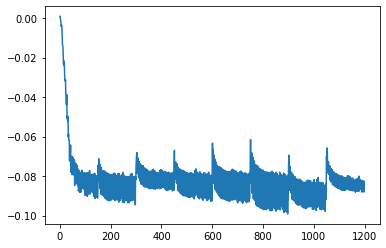

In [44]:
losses = []
for r in result[2].dropna()["training record"]:
    losses+=r["metrics"]["loss"]
plt.plot(losses)
plt.show()

1.4967236518859863 0.35144350369199845


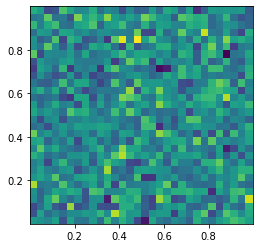

In [67]:
x,px,fx = integrator.sample_survey()
var,mean = torch.var_mean(fx/px)
print(mean.item(),sqrt(var))
fig, ax = plt.subplots()
fig.set_size_inches((4,4))
n=30
h1=ax.hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
plt.show()

1.4995330572128296 0.3782318248075798


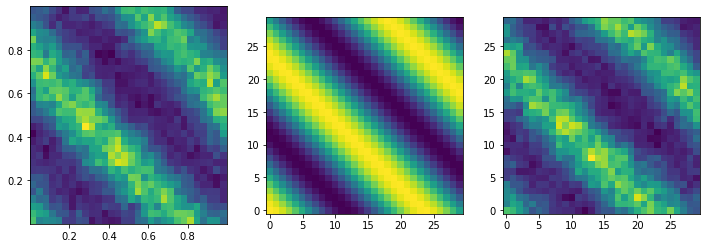

In [78]:
x,px,fx=integrator.sample_refine(n_points=100000)
var,mean = torch.var_mean(fx/px)
print(mean.item(),sqrt(var))
fig, axs = plt.subplots(1,3)
fig.set_size_inches((12,4))
n=30
h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
axs[1].imshow(nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
axs[2].imshow(h2[0],origin="lower")
plt.show()

In [69]:
func_sample = nonzerocos(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy()

In [77]:
fn = func_sample/np.sum(func_sample)
h1n = h1[0]/np.sum(h1[0])
h2n = h2[0]/np.sum(h2[0])
print((fn/h1n).var())
print((fn/h2n).var())

0.06714070190083665
0.10825351100705977


Quite annoying: the function has visibly been learned, the DKL has significantly decreased but the variance is actually worse!!

In [73]:
del model, trainer, integrator, x , px ,fx, optim

### making checks more systematic

In [166]:
def test_func(f, epochs=10, n_survey=1):
    model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
])

    trainer = BasicStatefulDKLTrainer(flow=model,latent_prior=prior)


    optim = torch.optim.Adam(model.parameters(),lr=1.e-3)

    trainer.set_config(n_epochs=epochs, minibatch_size=20000, optim=optim)

    integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device, verbosity=1, trainer_verbosity=0)
    
    result=integrator.integrate(n_survey,1)
    losses = []
    for r in result[2].dropna()["training record"]:
        losses+=r["metrics"]["loss"]
    plt.plot(losses)
    plt.show()
    
    x,px,fx = integrator.sample_survey()
    varf,meanf = torch.var_mean(fx/px)
    print(f"flat: {meanf} with var {varf}")
    x,px,fx = integrator.sample_refine()
    var,mean = torch.var_mean(fx/px)
    print(f"model: {mean} with var {var}")
    print(f"speed-up: {varf/var}")
    print("\n")

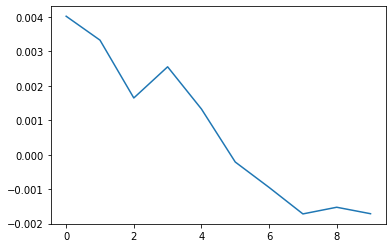

flat: 1.4978880882263184 with var 0.12346716225147247
model: 1.4974029064178467 with var 0.11627832800149918
speed-up: 1.0618243217468262




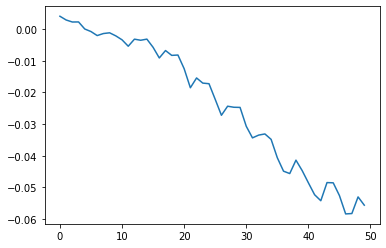

flat: 1.4964091777801514 with var 0.12327177077531815
model: 1.4971985816955566 with var 0.07337623089551926
speed-up: 1.6799958944320679




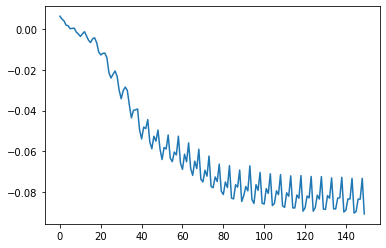

flat: 1.4978126287460327 with var 0.12325715273618698
model: 1.4963650703430176 with var 0.12522858381271362
speed-up: 0.9842573404312134




In [127]:
# Checking: there's a sweet spot: if we train the DKL too much we make things worse
test_func(nonzerocos,2,1)
test_func(nonzerocos,10,1)
test_func(nonzerocos,30,1)

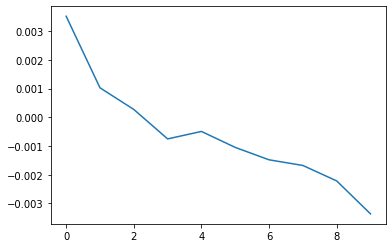

flat: 1.4970370531082153 with var 0.12317214161157608
model: 1.4955506324768066 with var 0.1151675209403038
speed-up: 1.0695041418075562




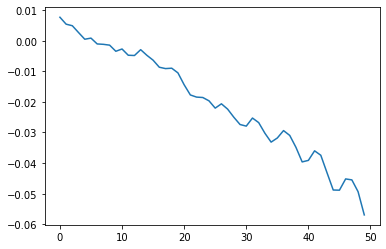

flat: 1.4971507787704468 with var 0.12335590273141861
model: 1.4976694583892822 with var 0.06517786532640457
speed-up: 1.8926042318344116




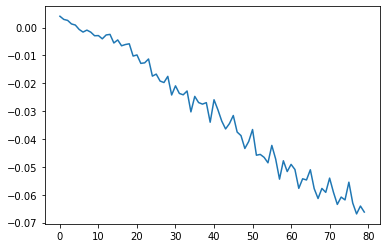

flat: 1.4963233470916748 with var 0.1236027181148529
model: 1.4976264238357544 with var 0.08564461767673492
speed-up: 1.4432047605514526




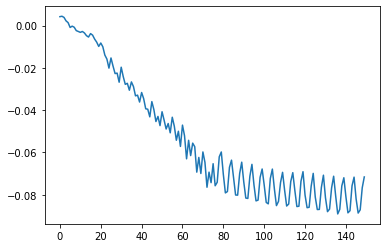

flat: 1.4964759349822998 with var 0.12315963208675385
model: 1.4996161460876465 with var 0.1303614228963852
speed-up: 0.9447551965713501




In [128]:
# Could it be overfitting? Not so far
test_func(nonzerocos,1,2)
test_func(nonzerocos,5,2)
test_func(nonzerocos,8,2)
test_func(nonzerocos,15,2)

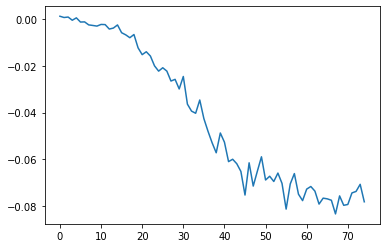

flat: 1.4959019422531128 with var 0.12278749793767929
model: 1.498194694519043 with var 0.11530854552984238
speed-up: 1.0648603439331055




In [129]:
# More aggressive attempt: slightly better
test_func(nonzerocos,1,15)

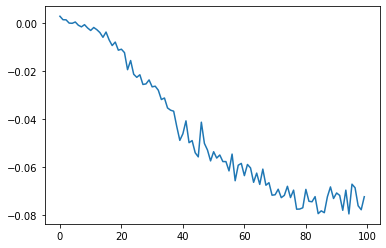

flat: 1.4970225095748901 with var 0.12327771633863449
model: 1.49796724319458 with var 0.10858773440122604
speed-up: 1.1352821588516235




In [130]:
# More aggressive attempt: still ends up not good
test_func(nonzerocos,1,20)

# Is this an issue with the DKL?

In [5]:
def test_func_var(f, epochs=10, n_survey=1, show_sample=False, lr=1.e-3):
    model  = InvertibleSequentialFlow(2,[
        PWLinearCoupling(d=2,
              mask=[True,False],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
        PWLinearCoupling(d=2,
              mask=[False,True],
              d_hidden=128,
              n_hidden=8,
              n_bins=30,
              hidden_activation=torch.nn.LeakyReLU,
              input_activation=Reshift,
              use_batch_norm=False).to(device),
])

    trainer = BasicStatefulVarTrainer(flow=model,latent_prior=prior)


    optim = torch.optim.Adam(model.parameters(),lr=lr)

    trainer.set_config(n_epochs=epochs, minibatch_size=20000, optim=optim)

    integrator=FlatSurveySamplingIntegrator(f,trainer,2,device=device, verbosity=1, trainer_verbosity=0)
    
    result=integrator.integrate(n_survey,1)
    losses = []
    for r in result[2].dropna()["training record"]:
        losses+=r["metrics"]["loss"]
    plt.plot(losses)
    plt.show()
    
    x,px,fx = integrator.sample_survey()
    varf,meanf = torch.var_mean(fx/px)
    print(f"flat: {meanf} with var {varf}")
    x,px,fx = integrator.sample_refine()
    var,mean = torch.var_mean(fx/px)
    print(f"model: {mean} with var {var}")
    print(f"speed-up: {varf/var}")
    print("\n")
    
    if show_sample:
        x,px,fx=integrator.sample_refine(n_points=100000)
        fig, axs = plt.subplots(1,3)
        fig.set_size_inches((12,4))
        n=30
        h2=axs[0].hist2d(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(),bins=n)
        axs[1].imshow(f(torch.cartesian_prod(torch.arange(0,1,1/n),torch.arange(0,1,1/n))).reshape(n,n).numpy(),origin="lower",)
        axs[2].imshow(h2[0],origin="lower")
        plt.show()
        
    return varf/var

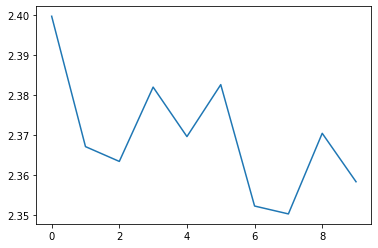

flat: 1.499391794204712 with var 0.12256903946399689
model: 1.4961109161376953 with var 0.1156235858798027
speed-up: 1.0600695610046387




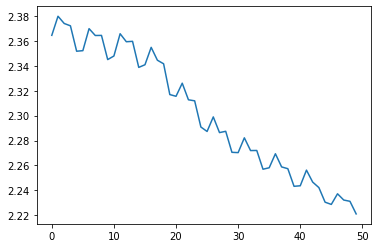

flat: 1.4979662895202637 with var 0.12339027971029282
model: 1.497233271598816 with var 0.014943772926926613
speed-up: 8.256969451904297




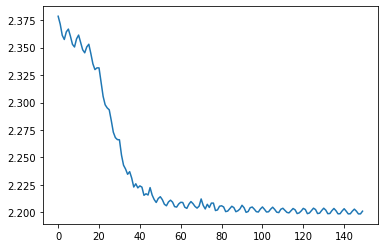

flat: 1.496566891670227 with var 0.12299785017967224
model: 1.497959852218628 with var 0.016485009342432022
speed-up: 7.461194038391113




In [133]:
test_func_var(nonzerocos,2,1)
test_func_var(nonzerocos,10,1)
test_func_var(nonzerocos,30,1)

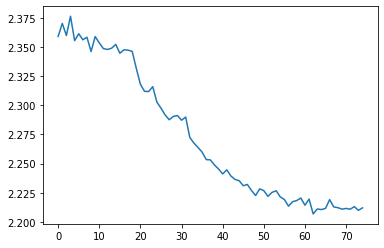

flat: 1.4961879253387451 with var 0.12291429191827774
model: 1.4975690841674805 with var 0.01334949117153883
speed-up: 9.207413673400879




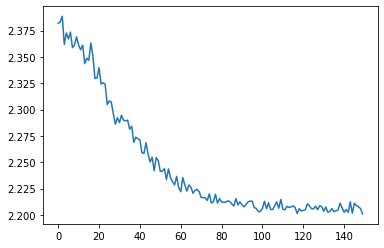

flat: 1.4954694509506226 with var 0.12317187339067459
model: 1.4968310594558716 with var 0.01563210040330887
speed-up: 7.879419326782227




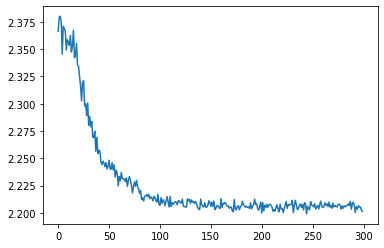

flat: 1.4972853660583496 with var 0.12300027161836624
model: 1.4977209568023682 with var 0.014896916225552559
speed-up: 8.256760597229004




In [137]:
test_func_var(nonzerocos,1,15)
test_func_var(nonzerocos,1,30)
test_func_var(nonzerocos,1,60)

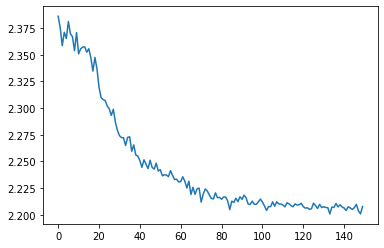

flat: 1.4966862201690674 with var 0.12323886156082153
model: 1.4965717792510986 with var 0.012720998376607895
speed-up: 9.68782901763916


1.4977506399154663 0.11284593271676185


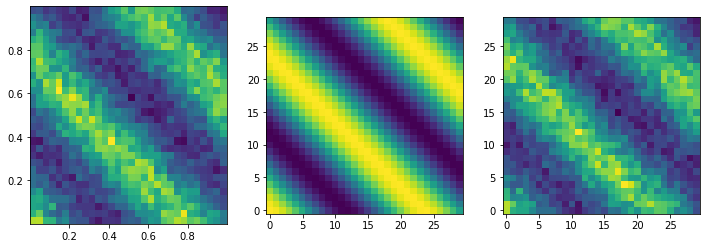

In [139]:
test_func_var(nonzerocos,1,30)

OK so it's clearly much better with the variance loss than the DKL loss to optimize the variance. Interesting because they have the same minimum but probably approaching it in a less ideal direction?

Let's try to validate with other functions

## Same function but actually goes to 0

In [6]:
def poscos(x):
    return torch.cos(4*(x[:,0]+x[:,1]))**2

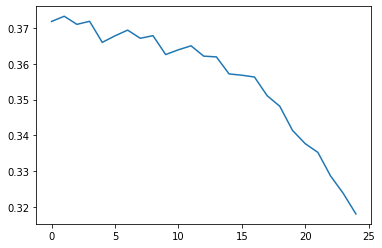

flat: 0.4972148537635803 with var 0.12272436916828156
model: 0.4976651072502136 with var 0.0696430578827858
speed-up: 1.7621909379959106




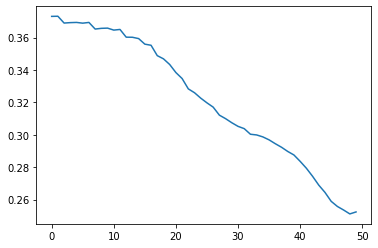

flat: 0.4967753291130066 with var 0.12350651621818542
model: 0.49706214666366577 with var 0.046387188136577606
speed-up: 2.662513494491577




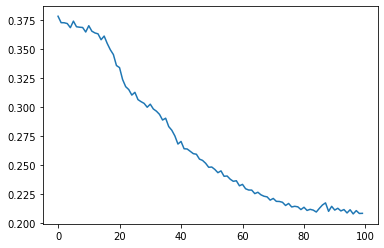

flat: 0.49719393253326416 with var 0.12332633882761002
model: 0.49703797698020935 with var 0.09351860731840134
speed-up: 1.3187358379364014




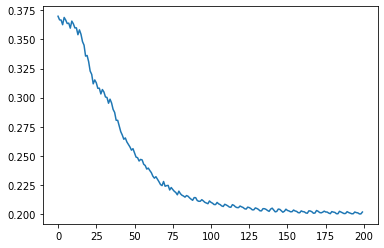

flat: 0.49728137254714966 with var 0.12301348894834518
model: 0.49732378125190735 with var 0.10874464362859726
speed-up: 1.1312142610549927




tensor(1.1312, device='cuda:7')

In [169]:
test_func_var(poscos,5,1,False)
test_func_var(poscos,10,1,False)
test_func_var(poscos,20,1,False)
test_func_var(poscos,40,1,False)

There seems to be a sweet spot with a single sample set. Let's go overboard the other way

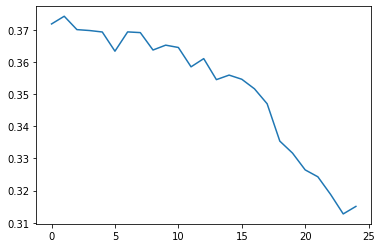

flat: 0.49828624725341797 with var 0.12271351367235184
model: 0.49698132276535034 with var 0.06790843605995178
speed-up: 1.8070436716079712




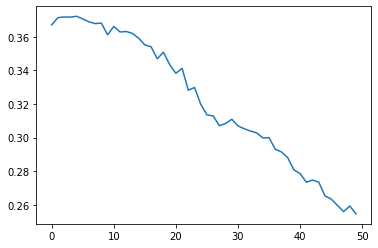

flat: 0.4958483576774597 with var 0.12333450466394424
model: 0.4979460537433624 with var 0.040759049355983734
speed-up: 3.0259416103363037




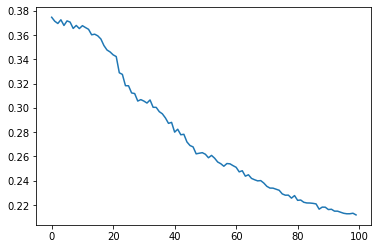

flat: 0.49660614132881165 with var 0.12333538383245468
model: 0.4966062903404236 with var 0.0719790905714035
speed-up: 1.713489055633545




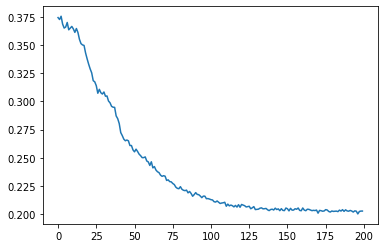

flat: 0.4960721433162689 with var 0.12313432991504669
model: 0.4973903298377991 with var 0.11272339522838593
speed-up: 1.0923582315444946




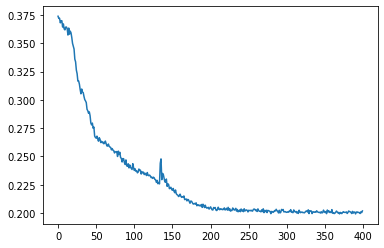

flat: 0.4976363182067871 with var 0.12293210625648499
model: 0.49621713161468506 with var 0.1397702693939209
speed-up: 0.8795297145843506




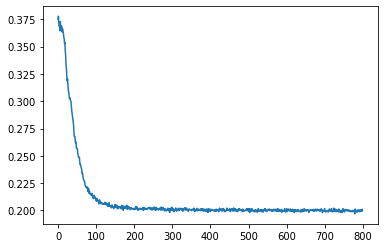

flat: 0.4965536594390869 with var 0.12331841140985489
model: 0.49596554040908813 with var 0.15391750633716583
speed-up: 0.8011980652809143




tensor(0.8012, device='cuda:7')

In [170]:
test_func_var(poscos,1,5,False)
test_func_var(poscos,1,10,False)
test_func_var(poscos,1,20,False)
test_func_var(poscos,1,40,False)
test_func_var(poscos,1,80,False)
test_func_var(poscos,1,160,False)

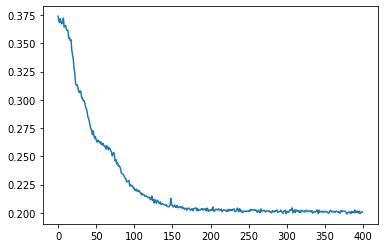

flat: 0.4978238642215729 with var 0.12320904433727264
model: 0.49720707535743713 with var 0.14365564286708832
speed-up: 0.8576693534851074


0.4967935085296631 0.3767841138108392


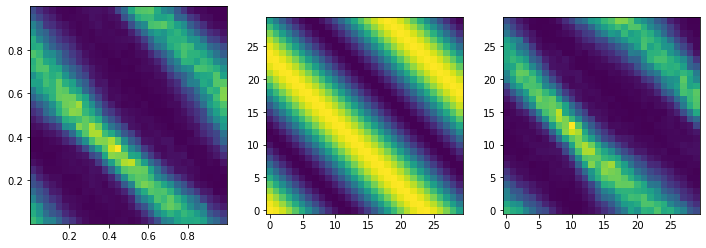

tensor(0.8679, device='cuda:7')

In [171]:
test_func_var(poscos,1,80,True)

## Camel function

In [7]:
def camel(x):
    return torch.exp(- torch.sum(((x-.25)/0.1)**2,dim=-1)  )+torch.exp(- torch.sum(((x-.75)/0.1)**2,dim=-1)  )

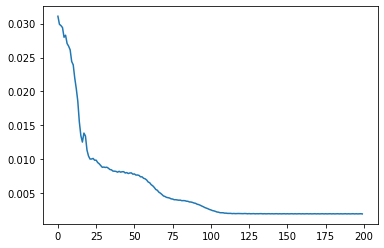

flat: 0.062390007078647614 with var 0.02727658860385418
model: 0.062434181571006775 with var 1.967203140258789
speed-up: 0.013865669257938862


0.06448482722043991 1.8397875734730849


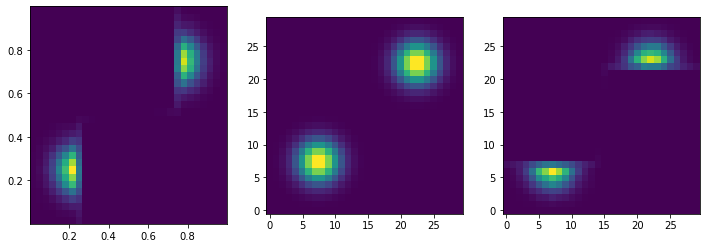

tensor(0.0081, device='cuda:7')

In [179]:
test_func_var(camel,40,1,True)

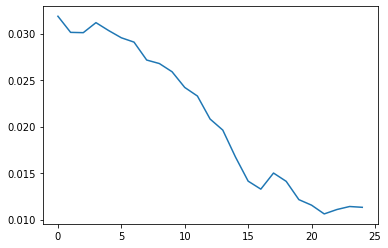

flat: 0.063100665807724 with var 0.027774371206760406
model: 0.06261006742715836 with var 0.0067225294187664986
speed-up: 4.13153600692749


0.06272608041763306 0.08210585811680016


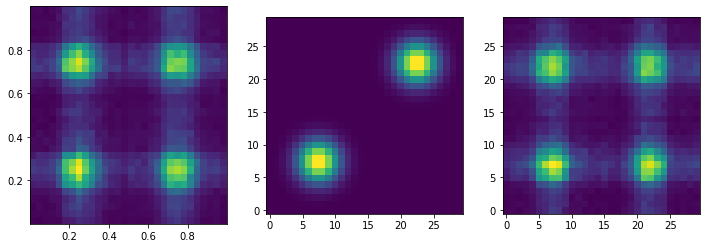

tensor(4.1200, device='cuda:7')

In [182]:
test_func_var(camel,1,5,True)

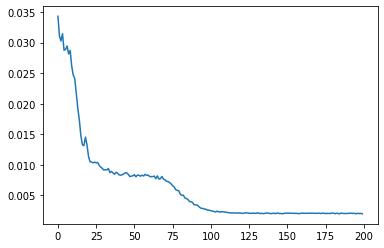

flat: 0.06245218962430954 with var 0.02733953855931759
model: 0.06785577535629272 with var 2.872753381729126
speed-up: 0.009516841731965542


0.06024302542209625 1.1980632471160573


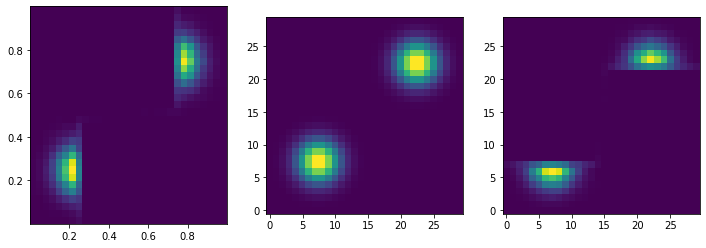

tensor(0.0190, device='cuda:7')

In [183]:
test_func_var(camel,1,40,True)

So for short times we're learning "VEGAS-style" but then we create "wrong" peaks

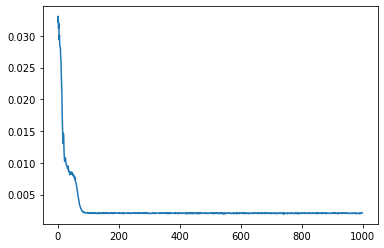

flat: 0.06301155686378479 with var 0.027597961947321892
model: 0.0652337595820427 with var 3.077862024307251
speed-up: 0.008966601453721523


0.0602494552731514 1.7229319933479041


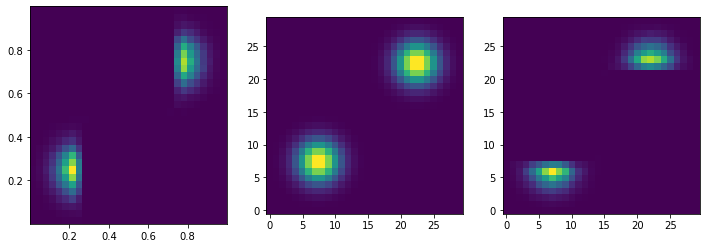

tensor(0.0093, device='cuda:7')

In [185]:
test_func_var(camel,1,200,True)

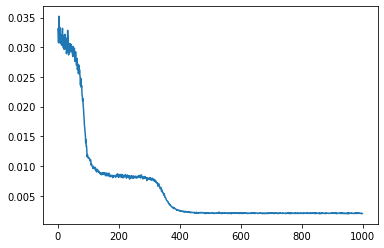

flat: 0.06340096890926361 with var 0.027783159166574478
model: 0.050746895372867584 with var 0.7624168992042542
speed-up: 0.0364409014582634


0.06184752658009529 2.05518778813091


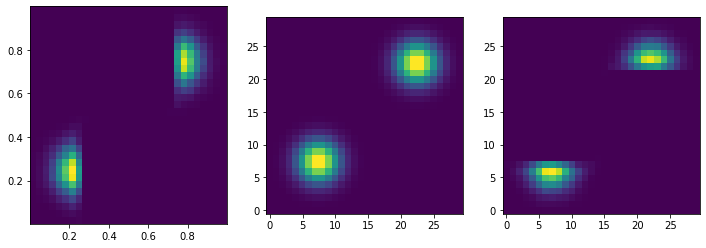

tensor(0.0066, device='cuda:7')

In [186]:
test_func_var(camel,1,200,True,lr=1.e-4)

## Is it a problem with zero?

In [6]:
def nonzerocamel(reg):
    def camel(x):
        return reg+torch.exp(- torch.sum(((x-.25)/0.1)**2,dim=-1)  )+torch.exp(- torch.sum(((x-.75)/0.1)**2,dim=-1)  )
    return camel

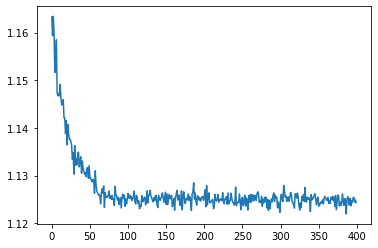

flat: 1.0621345043182373 with var 0.027110183611512184
model: 1.0632206201553345 with var 0.0021094020921736956
speed-up: 12.852069854736328




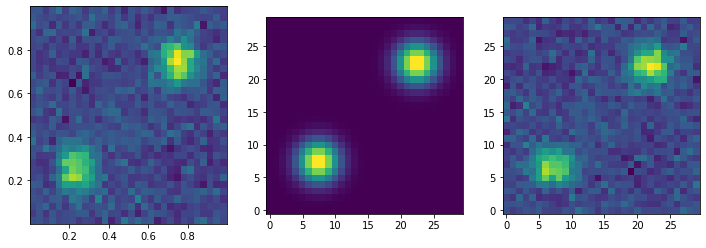

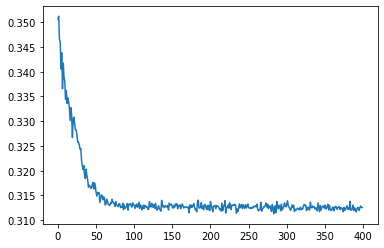

flat: 0.5626407265663147 with var 0.02759455516934395
model: 0.5628606081008911 with var 0.0016682706773281097
speed-up: 16.540813446044922




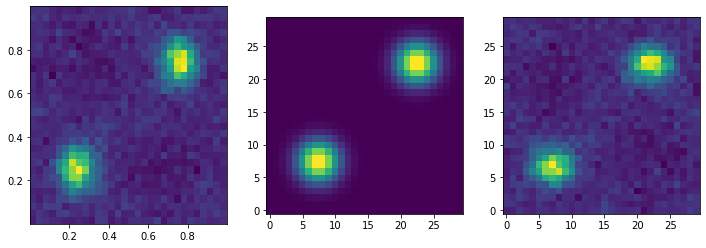

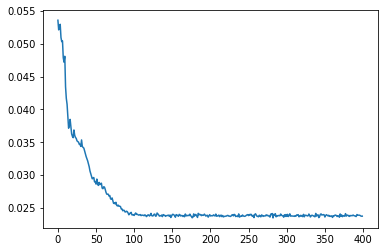

flat: 0.163053959608078 with var 0.02749394252896309
model: 0.16290977597236633 with var 0.0022988419514149427
speed-up: 11.959909439086914




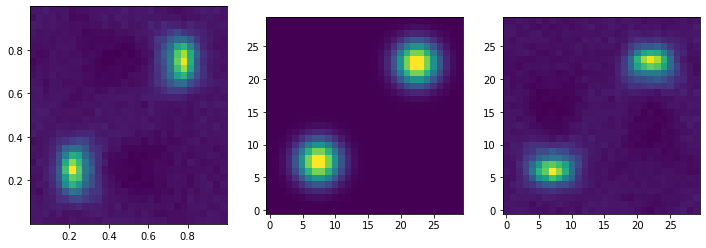

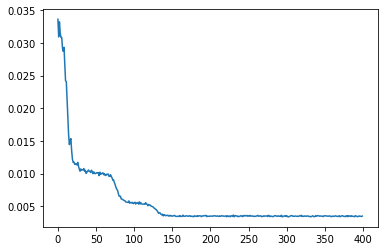

flat: 0.07291026413440704 with var 0.02780243381857872
model: 0.07311046123504639 with var 0.008759385906159878
speed-up: 3.174016237258911




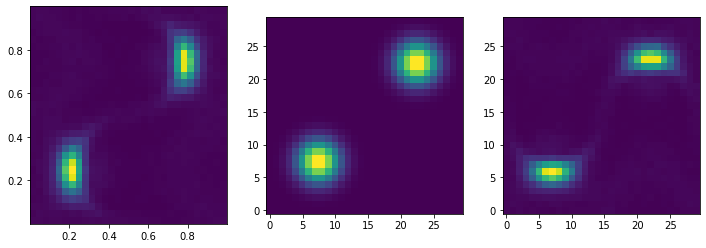

tensor(3.1740, device='cuda:7')

In [199]:
test_func_var(nonzerocamel(1.),1,80,True)
test_func_var(nonzerocamel(.5),1,80,True)
test_func_var(nonzerocamel(.1),1,80,True)
test_func_var(nonzerocamel(.01),1,80,True)

Yep, seems like it. Niklas is getting the opposite behavior, is it due to the training mode?

# Testing with the inverted model

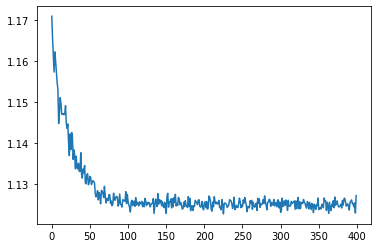

flat: 1.0630372762680054 with var 0.02753724716603756
model: 1.0628443956375122 with var 0.0016747957561165094
speed-up: 16.44215202331543




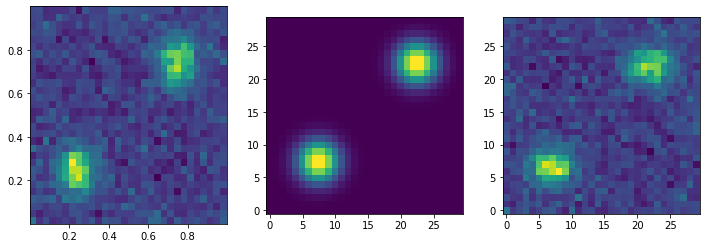

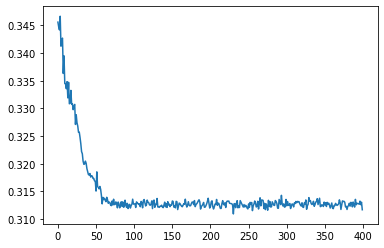

flat: 0.5618152022361755 with var 0.02685718983411789
model: 0.5627220273017883 with var 0.0016136065823957324
speed-up: 16.64419937133789




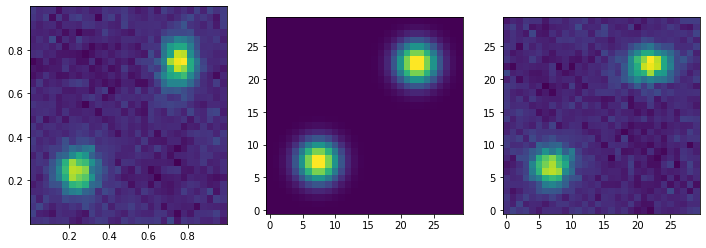

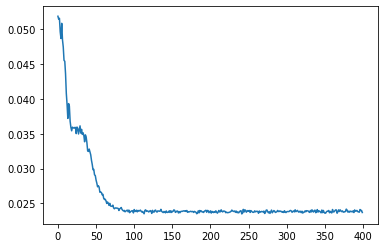

flat: 0.16302500665187836 with var 0.027302362024784088
model: 0.16290192306041718 with var 0.002318524057045579
speed-up: 11.775751113891602




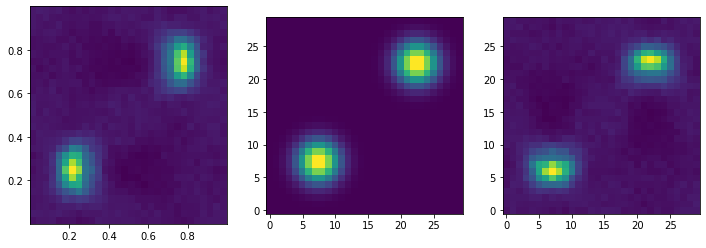

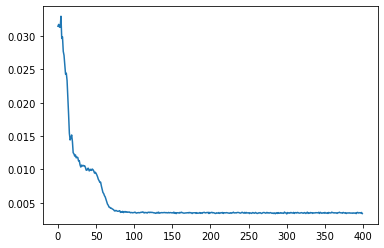

flat: 0.07310223579406738 with var 0.027619902044534683
model: 0.07304928451776505 with var 0.008858386427164078
speed-up: 3.117938280105591




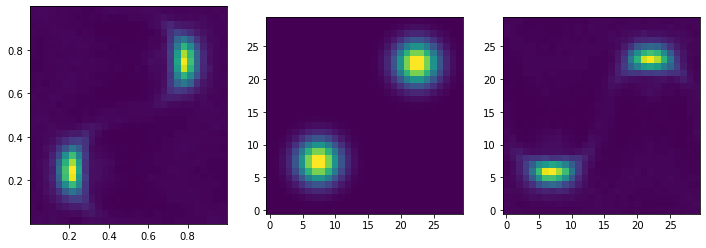

tensor(3.1179, device='cuda:7')

In [7]:
test_func_var(nonzerocamel(1.),1,80,True)
test_func_var(nonzerocamel(.5),1,80,True)
test_func_var(nonzerocamel(.1),1,80,True)
test_func_var(nonzerocamel(.01),1,80,True)